# Common IIR filters

In the last section, we were introduced to the *Butterworth* filter, which is one of the earliest and most commonly used IIR filters.
In this section, we'll meet a few more types of IIR filter.
None of them are necessarily better or worse than the others: they each have benefits and drawbacks.
Having a sense of the various trade-offs made by each type of filter is important if you plan to apply these in practice.

In [1]:
%run ../setup.ipynb

## Chebyshev filters

The next family of filters that we'll see are known as *Chebyshev* filters, named for the mathematician [Pafnuty Chebyshev](https://en.wikipedia.org/wiki/Pafnuty_Chebyshev), who initially developed the underlying family of polynomial functions upon which the filters are based.
There are two types of Chebyshev filters, not-so-conveniently named *Type 1* and *Type 2*.

### Type 1

Type-1 Chebyshev filters have a steeper transition than Butterworth filters, at the expense of introducing ripple in the pass-band.
They are constructed by the function `scipy.signal.cheby1`, which has as its key parameters:

- the order of the filter, which can be derived by `scipy.signal.cheby1ord`,
- the maximum amount of passband ripple we'll allow, and
- the cutoff frequency.

Continuing our example from the previous section, a 500 Hz low-pass filter could be constructed as follows:

```{code-block} python
fs = 44100  # Sampling rate
fc = 500  # Cutoff frequency
fstop = 1000  # stop-band at 1000

ripple = 3  # we'll allow 3 dB ripple in the passband
attenuation = 60  # we'll require 60 dB attenuation in the stop band

# Get the order and discard the second output (natural frequency)
order, _  = scipy.signal.cheb1ord(fc, fstop, ripple, attenuation, fs=fs)

# Build the filter
b, a = scipy.signal.cheby1(order, ripple, fc, fs=fs)
```

{numref}`cheby1` illustrates the results of applying this filter to an impulse $x$, and how it compares to a Butterworth filter.

In [104]:
fs = 44100  # Sampling rate
fc = 500  # Cutoff frequency
fstop = 1000
ripple = 3  # we'll allow 3 dB ripple in the passband
attenuation = 60  # we'll require 60 dB attenuation in the stop band

order, _ = scipy.signal.cheb1ord(fc, fstop, ripple, attenuation, fs=fs)
b, a = scipy.signal.cheby1(order, ripple, fc, fs=fs)

bbutt, abutt = scipy.signal.butter(order, fc, fs=fs)

N = 2000
x = np.zeros(N)
x[0] = 1
y = scipy.signal.lfilter(b, a, x)
ybutt = scipy.signal.lfilter(bbutt, abutt, x)

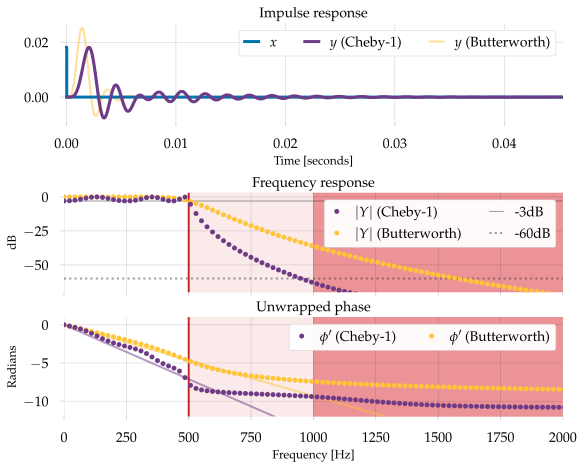

In [122]:
fig, (axt, axf, axp) = plt.subplots(nrows=3, figsize=figaspect(0.8))

axt.step(np.arange(N) / fs, x * y.max(), where='post', label='$x$')
axt.step(np.arange(N) / fs, y, where='post', label='$y$ (Cheby-1)', color=colors[4])
axt.step(np.arange(N) / fs, ybutt, where='post', label='$y$ (Butterworth)', color=colors[2], zorder=-1, linewidth=2, alpha=0.5)
axt.legend(loc='upper right', ncol=3)
axt.set(xlabel='Time [seconds]', title='Impulse response', xlim=[-10/fs, N/fs])

Y = np.fft.rfft(y)
Ybutt = np.fft.rfft(ybutt)
freqs = np.fft.rfftfreq(N, 1/fs)

axf.plot(freqs, 20 * np.log10(np.abs(Y) + 1e-6), linestyle='', marker='.', color=colors[4], label='$|Y|$ (Cheby-1)', zorder=5)
axf.plot(freqs, 20 * np.log10(np.abs(Ybutt) + 1e-6), linestyle='', marker='.', color=colors[2], label='$|Y|$ (Butterworth)')
axf.axvline(fc, color=colors[1], zorder=-1, linewidth=2)
axf.axvspan(fc, fstop, color=colors[1], zorder=-1, alpha=0.1)
axf.axvspan(fstop, fs/2, color=colors[1], zorder=-1, alpha=0.5)
axf.axhline(-3, color=colors[3], zorder=-1, linewidth=1, alpha=0.5, label='-3dB')
axf.axhline(-60, color=colors[3], zorder=-1, linestyle=':', linewidth=2, alpha=0.5, label='-60dB')
axf.set(xlim=[0, 2000], ylim=[-70, 3], ylabel='dB', title='Frequency response')
axf.label_outer()
axf.legend(loc='upper right', ncol=2)

phase = np.unwrap(np.angle(Y))
phasebutt = np.unwrap(np.angle(Ybutt))
delay = np.diff(phase) / freqs[1]
delaybutt = np.diff(phasebutt) / freqs[1]

M = np.searchsorted(freqs, fc)
axp.plot(freqs, phase, linestyle='', marker='.', color=colors[4], label="$\\phi'$ (Cheby-1)", zorder=5)
axp.axline((freqs[0], phase[0]), xy2=(freqs[M-1], phase[M-1]), color=colors[4], linewidth=2, alpha=0.5, zorder=0)
axp.plot(freqs, phasebutt, linestyle='', marker='.', color=colors[2], label="$\\phi'$ (Butterworth)")
axp.axline((freqs[0], phasebutt[0]), xy2=(freqs[M-1], phasebutt[M-1]), color=colors[2], linewidth=2, alpha=0.5, zorder=0)

axp.axvline(fc, color=colors[1], zorder=-1, linewidth=2)
axp.axvspan(fc, fstop, color=colors[1], zorder=-1, alpha=0.1)
axp.axvspan(fstop, fs/2, color=colors[1], zorder=-1, alpha=0.5)
axp.set(xlim=[0, 2000], ylim=[-12, 1], ylabel='Radians', xlabel='Frequency [Hz]', title='Unwrapped phase')
axp.label_outer()
axp.legend(loc='upper right', ncol=2)
glue('cheby1', fig, display=False)

```{glue:figure} cheby1
:name: cheby1

A type-1 Chebyshev filter with 3dB passband ripple, cutoff frequency of $f_c=500$, and stop-band starting at 1000 Hz is applied to an impulse $x$ to produce the impulse response $y$, measured for 2000 samples (at $f_s=44100$).
For comparison purposes, a Butterworth filter with the same cutoff and order is also computed.
**Top**: the impulse, and impulse response.
**Middle**: the DFT magnitude $|Y|$ measured in decibels.
**Bottom**: the unwrapped phase spectrum $\phi'$.
```

As {numref}`cheby1` illustrates, the frequency response drops much more rapidly after $f_c$ than that of the Butterworth filter.
The cost of this is two-fold:

1. There is ripple in the pass-band: $|Y|$ is not constant for frequencies below $f_c$.
2. There is more phase distortion: $\phi'$ deviates significantly from linear phase (plotted as a straight line).



### Type 2

Type-2 Chebyshev filters are similar to type-1, except the pass-band remains flat and ripple is allowed in the *stop-band*.
Type-2 filters are constructed by `scipy.signal.cheby2`, which is similar to the `cheby1` function above, but with two key differences:

1. The stop-band attenuation is provided, instead of the pass-band ripple, and
2. The **end** of the transition region is provided, rather than the cutoff frequency $f_c$.

Similarly, the order of the filter is computed by `scipy.signal.cheb2ord`, which takes all the same parameters as `cheb1ord`.

```{code-block} python
# Get the order and discard the second output (natural frequency)
order2, _  = scipy.signal.cheb2ord(fc, fstop, ripple, attenuation, fs=fs)

# Build the filter
b2, a2 = scipy.signal.cheby2(order2, attenuation, fstop, fs=fs)
```

{numref}`cheby2` illustrates the behavior of the type-2 filter, compared to the type-1 filter with similar constraints.

In [105]:
fs = 44100  # Sampling rate
fc = 500  # Cutoff frequency
fstop = 1000
attenuation = 60  # we'll require 60 dB attenuation in the stop band

order, _ = scipy.signal.cheb2ord(fc, fstop, ripple, attenuation, fs=fs)
bc2, ac2 = scipy.signal.cheby2(order, attenuation, fstop, fs=fs)

N = 2000
x = np.zeros(N)
x[0] = 1
yc2 = scipy.signal.lfilter(bc2, ac2, x)

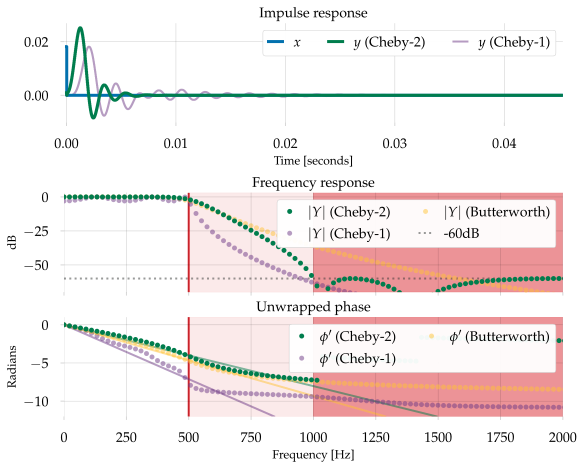

In [124]:
fig, (axt, axf, axp) = plt.subplots(nrows=3, figsize=figaspect(0.8))

axt.step(np.arange(N) / fs, x * y.max(), where='post', label='$x$')
axt.step(np.arange(N) / fs, yc2, where='post', label='$y$ (Cheby-2)', color=colors[5])
axt.step(np.arange(N) / fs, y, where='post', label='$y$ (Cheby-1)', color=colors[4], zorder=-1, linewidth=2, alpha=0.5)
axt.legend(loc='upper right', ncol=3)
axt.set(xlabel='Time [seconds]', title='Impulse response', xlim=[-10/fs, N/fs])

Yc2 = np.fft.rfft(yc2)

axf.plot(freqs, 20 * np.log10(np.abs(Yc2) + 1e-6), linestyle='', marker='.', color=colors[5], label='$|Y|$ (Cheby-2)', zorder=5)
axf.plot(freqs, 20 * np.log10(np.abs(Y) + 1e-6), linestyle='', marker='.', color=colors[4], label='$|Y|$ (Cheby-1)', alpha=0.5)
axf.plot(freqs, 20 * np.log10(np.abs(Ybutt) + 1e-6), linestyle='', marker='.', color=colors[2], zorder=0, label='$|Y|$ (Butterworth)', alpha=0.5)
axf.axhline(-60, color=colors[3], zorder=-1, linewidth=2, linestyle=':', alpha=0.5, label='-60dB')
axf.axvline(fc, color=colors[1], zorder=-1, linewidth=2)
axf.axvspan(fc, fstop, color=colors[1], zorder=-1, alpha=0.1)
axf.axvspan(fstop, fs/2, color=colors[1], zorder=-1, alpha=0.5)
axf.set(xlim=[0, 2000], ylim=[-70, 3], ylabel='dB', title='Frequency response')
axf.label_outer()
axf.legend(loc='upper right', ncol=2)

phasec2 = np.unwrap(np.angle(Yc2))

M = np.searchsorted(freqs, fc)
axp.plot(freqs, phasec2, linestyle='', marker='.', color=colors[5], label="$\\phi'$ (Cheby-2)", zorder=5)
axp.axline((freqs[0], phasec2[0]), xy2=(freqs[M-1], phasec2[M-1]), color=colors[5], linewidth=2, alpha=0.5, zorder=0)
axp.plot(freqs, phase, linestyle='', marker='.', color=colors[4], label="$\\phi'$ (Cheby-1)", alpha=0.5)
axp.axline((freqs[0], phase[0]), xy2=(freqs[M-1], phase[M-1]), color=colors[4], linewidth=2, alpha=0.5, zorder=0)
axp.plot(freqs, phasebutt, linestyle='', marker='.', color=colors[2], label="$\\phi'$ (Butterworth)", alpha=0.5)
axp.axline((freqs[0], phasebutt[0]), xy2=(freqs[M-1], phasebutt[M-1]), color=colors[2], linewidth=2, alpha=0.5, zorder=0)

axp.axvline(fc, color=colors[1], zorder=-1, linewidth=2)
axp.axvspan(fc, fstop, color=colors[1], zorder=-1, alpha=0.1)
axp.axvspan(fstop, fs/2, color=colors[1], zorder=-1, alpha=0.5)
axp.set(xlim=[0, 2000], ylim=[-12, 1], ylabel='Radians', xlabel='Frequency [Hz]', title='Unwrapped phase')
axp.label_outer()
axp.legend(loc='upper right', ncol=2)
glue('cheby2', fig, display=False)

```{glue:figure} cheby2
:name: cheby2

A type-2 Chebyshev filter with 60dB stop-band attenuation, cutoff frequency of $f_c=500$, and stop-band starting at 1000 Hz..
The Butterworth and type-1 filters from {numref}`cheby1` are included for comparison purposes.
**Top**: the impulse, and impulse response.
**Middle**: the DFT magnitude $|Y|$ measured in decibels.
**Bottom**: the unwrapped phase spectrum $\phi'$.
```

Compared to the type-1 filter, {numref}`cheby2` shows that the type-2 filter has a shallower transition, though it is still steeper than that of the Butterworth filter.
Note that the pass-band frequency response has no ripple, and the phase is much closer to linear.
We should therefore expect better preservation of the low-frequency content with the type-2 filter than with the type-1 filter.
The main cost is that the transition region has less attenuation, so the filter will not be as *sharp*, and frequencies above $f_c$ will propagate through slightly more with the type-2 filter.

## Elliptic filters

So far, we've seen:

- the Butterworth filter, which has no ripple in either the pass-band or the stop-band;
- the type-1 Chebyshev filter, which has pass-band ripple but no stop-band ripple; and
- the type-2 Chebyshev filter, which has stop-band ripple but no pass-band ripple.

If we allow ripple in *both* the pass- and stop-bands, we get what are known as **elliptic** filters.
The main benefit of elliptic filters is that they can have extremely steep transitions.

Elliptic filters are provided by `scipy.signal.ellip` (and with order helper `scipy.signal.ellipord`).
The `ellip` function can be thought of as generalizing both `cheby1` and `cheby2`, so it requires all of the parameters of either individual function:

- the order of the filter;
- the pass-band ripple;
- the stop-band attenuation; and
- the cutoff frequency (like in `cheby1`, not the end of the transition like in `cheby2`!)

The `ellipord` helper function works just like `cheby1` and `cheby2`, and the following code can be used to construct an elliptic low-pass filter:

```{code-block} python
# Get the order and discard the second output (natural frequency)
order_ell, _  = scipy.signal.ellipord(fc, fstop, ripple, attenuation, fs=fs)

# Build the filter
b_ell, a_ell = scipy.signal.ellip(order_ell, ripple, attenuation, fc, fs=fs)
```

In [133]:
fs = 44100  # Sampling rate
fc = 500  # Cutoff frequency
fstop = 1000
attenuation = 60  # we'll require 60 dB attenuation in the stop band

order_ell, _ = scipy.signal.ellipord(fc, fstop, ripple, attenuation, fs=fs)
b_ell, a_ell = scipy.signal.ellip(order, ripple, attenuation, fc, fs=fs)

N = 2000
x = np.zeros(N)
x[0] = 1
y_ell = scipy.signal.lfilter(b_ell, a_ell, x)

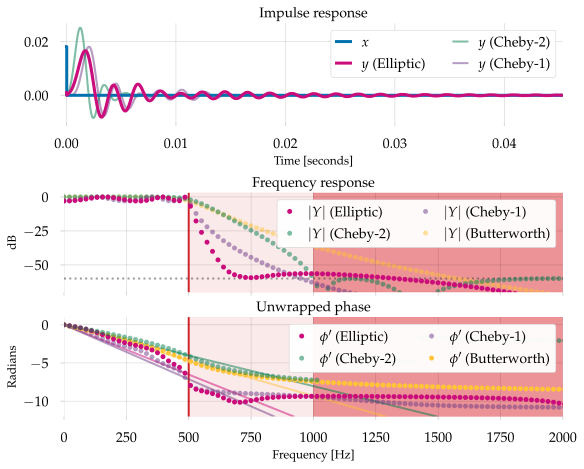

In [137]:
fig, (axt, axf, axp) = plt.subplots(nrows=3, figsize=figaspect(0.8))

axt.step(np.arange(N) / fs, x * y.max(), where='post', label='$x$')
axt.step(np.arange(N) / fs, y_ell, where='post', label='$y$ (Elliptic)', color=colors[8])
axt.step(np.arange(N) / fs, yc2, where='post', label='$y$ (Cheby-2)', color=colors[5], zorder=-1, alpha=0.5, linewidth=2)
axt.step(np.arange(N) / fs, y, where='post', label='$y$ (Cheby-1)', color=colors[4], zorder=-2, alpha=0.5, linewidth=2)
axt.legend(loc='upper right', ncol=2)
axt.set(xlabel='Time [seconds]', title='Impulse response', xlim=[-10/fs, N/fs])

Yell = np.fft.rfft(y_ell)

axf.plot(freqs, 20 * np.log10(np.abs(Yell) + 1e-6), linestyle='', marker='.', color=colors[8], label='$|Y|$ (Elliptic)', zorder=5)
axf.plot(freqs, 20 * np.log10(np.abs(Yc2) + 1e-6), linestyle='', marker='.', color=colors[5], label='$|Y|$ (Cheby-2)', alpha=0.5)
axf.plot(freqs, 20 * np.log10(np.abs(Y) + 1e-6), linestyle='', marker='.', color=colors[4], label='$|Y|$ (Cheby-1)', alpha=0.5)
axf.plot(freqs, 20 * np.log10(np.abs(Ybutt) + 1e-6), linestyle='', marker='.', color=colors[2], zorder=0, label='$|Y|$ (Butterworth)', alpha=0.5)
axf.axhline(-60, color=colors[3], zorder=-1, linewidth=2, linestyle=':', alpha=0.5)
axf.axvline(fc, color=colors[1], zorder=-1, linewidth=2)
axf.axvspan(fc, fstop, color=colors[1], zorder=-1, alpha=0.1)
axf.axvspan(fstop, fs/2, color=colors[1], zorder=-1, alpha=0.5)
axf.set(xlim=[0, 2000], ylim=[-70, 3], ylabel='dB', title='Frequency response')
axf.label_outer()
axf.legend(loc='upper right', ncol=2)

phaseell = np.unwrap(np.angle(Yell))

M = np.searchsorted(freqs, fc)
axp.plot(freqs, phaseell, linestyle='', marker='.', color=colors[8], label="$\\phi'$ (Elliptic)", zorder=5)
axp.axline((freqs[0], phaseell[0]), xy2=(freqs[M-1], phaseell[M-1]), color=colors[8], linewidth=2, alpha=0.5, zorder=0)
axp.plot(freqs, phasec2, linestyle='', marker='.', color=colors[5], label="$\\phi'$ (Cheby-2)", zorder=5, alpha=0.5)
axp.axline((freqs[0], phasec2[0]), xy2=(freqs[M-1], phasec2[M-1]), color=colors[5], linewidth=2, alpha=0.5, zorder=0)
axp.plot(freqs, phase, linestyle='', marker='.', color=colors[4], label="$\\phi'$ (Cheby-1)", alpha=0.5)
axp.axline((freqs[0], phase[0]), xy2=(freqs[M-1], phase[M-1]), color=colors[4], linewidth=2, alpha=0.5, zorder=0)
axp.plot(freqs, phasebutt, linestyle='', marker='.', color=colors[2], label="$\\phi'$ (Butterworth)")
axp.axline((freqs[0], phasebutt[0]), xy2=(freqs[M-1], phasebutt[M-1]), color=colors[2], linewidth=2, alpha=0.5, zorder=0)

axp.axvline(fc, color=colors[1], zorder=-1, linewidth=2)
axp.axvspan(fc, fstop, color=colors[1], zorder=-1, alpha=0.1)
axp.axvspan(fstop, fs/2, color=colors[1], zorder=-1, alpha=0.5)
axp.set(xlim=[0, 2000], ylim=[-12, 1], ylabel='Radians', xlabel='Frequency [Hz]', title='Unwrapped phase')
axp.label_outer()
axp.legend(loc='upper right', ncol=2)
glue('elliptic', fig, display=False)

```{glue:figure} elliptic
:name: elliptic

An elliptic filter with 3dB pass-band ripple, 60dB stop-band attenuation, cutoff frequency of $f_c=500$, and stop-band starting at 1000 Hz..
Butterworth and Chebyshev filters are included for comparison purposes.
**Top**: the impulse, and impulse response.
**Middle**: the DFT magnitude $|Y|$ measured in decibels.
**Bottom**: the unwrapped phase spectrum $\phi'$.
```

{numref}`elliptic` shows that allowing ripple in both the pass- and stop-bands allows the Elliptic filter to achieve a much steeper transition than either type-1 or type-2 Chebyshev filters.
Note, however, that this also results in quite a bit of phase distortion in the Elliptic filter.

## Summary

The examples above are by no means exhaustive, and merely illustrate a few features of each of the filters in question.
Notably, we did not vary the ripple, attenuation, or transition region constraints here, and these parameters have enormous influence on the behavior of the filters.
For example, allowing more ripple (type-1 or elliptic) can provide a steeper transition.

So which filter should you use?  **It depends!**  (I know, not so helpful of an answer.)

A few things to keep in mind:

1. If you do not want any attenuation of pass-band frequencies, stick to Butterworth or Type-2 Chebyshev.
2. How much phase distortion can you tolerate?  Or can you compensate for it by using bidirectional filtering?
3. If you need steep transitions, Elliptic might be the best option.

The table below summarizes the properties of the four filter types we've seen.


| Filter type   | Pass-band ripple | Stop-band ripple | Transition    | Phase distortion |
| :--- | ---: | ---: | ---: | ---: |
| Butterworth | ✗ | ✗ | Slow | Small | 
| Chebyshev (Type-1) | ✓ | ✗ | Medium | Medium |
| Chebyshev (Type-2) | ✗ | ✓ | Medium | Small |
| Elliptic | ✓ | ✓ | Fast | Large |